<a href="https://colab.research.google.com/github/kode-git/ViT-emotion-recognition/blob/main/ViT_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Face Emotion Recognition


## 1. Introduction


ViT Face Emotion Recognition is a project based on the use of transformers for image classification. In our project we demostrates that transformers are able to classify some images in tasks like emotion recognition. The project has 3 different datasets in input that must be integrated in one and homogeneus dataset. Firstly, we need to resize images using a 224x224 total dimension because transformers has a same linear size for the input and the patching phase needs the same amount of data. The result subsets must be merged in one dataset called ViT. 

ViT Dataset is formed by 8 different classes integrated by 3 different subsets:
1. FER-2013: Fer2013 contains approximately 30,000 facial RGB images of different expressions with size restricted to 48×48, and the main labels of it can be divided into 7 types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has the minimal number of images – 600, while other labels have nearly 5,000 samples each.
2. CK+: The Extended Cohn-Kanade (CK+) dataset contains some images extrapolated from 593 video sequences from a total of 123 different subjects, ranging from 18 to 50 years of age with a variety of genders and heritage. Each video shows a facial shift from the neutral expression to a targeted peak expression, recorded at 30 frames per second (FPS) with a resolution of either 640x490 or 640x480 pixels. Unfortunately, we don't have the entire generated datasets but we stored only 1000 images with high variance from a kaggle repository. 
3. AffectNet: It is a large facial expression dataset with 40k images classified in eight categories (neutral, happy, angry, sad, fear, surprise, disgust, contempt) of facial expressions along with the intensity of valence and arousal.

Each dataset focus RGB channels for the coloring and have different sizes and image extensions entirely stored into Google Drive (the total amount of data are around 2 GB). So, we need to estabilish a standard format to manage them in the same way. Finally, we will pass in a data augmentation phase to improve the total amount of images to balance the number of samples for each category. 

Final sections interests in the fine-tuning phase and training on few models which can be saved locally on the drive and used in an external application for the real-time classification on an ad-hoc application. More information about modelling are in the next sections.

In [ ]:
!pip3 install Pillow

## 2. Data Retrieval

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import keras, os, cv2, glob
from google.colab import drive

In [2]:
from PIL import Image

Data sources about datasets described in the previous section are stored in Google Drive, so we need to manage file in a shared directory and integrate them in a single units with merging images of the same classes from different datasets.

Loading data from the Google Drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


The next snippet of code describes important functions used for the integration, ImageWorker is a class which we can use to convert the size format of an image (to make them in a standard dimension), changing the extension of an image and can evaluate the number of images per class in each of interested datasets.

In [5]:
class ImageWorker():

    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_type, dest_path):
        """format_converter : void

        Args:
            path (str): The source path of the images folder 
            format (str): Format of the images in the folder
            source_type (str): Type of the dataset 
            dest_path (str): Destination path to store resized images
        """        
        count = 0

        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
            print('Resized writing for', dest_path + "resized_on_" + source_type + "_" + str(count) + "." + format_img )
            cv2.imwrite(dest_path + "resized_on_" + source_type + "_" + str(count) + "."+ format_img, resized)
            count += 1


    def list_classes(self, dataset_path):
        """list_classes : list

        Args:
            abs_path (str): Absolute Path with marker for the listing classes on a dataset folder
        """   
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """counter_samples_on_class : dict

        Args:
            dataset_path (str): Absolute Path with marker for the listing classes on a dataset folder
      """   
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
     """counter_samples : int

        Args:
            dataset_path (str): Absolute Path with marker for the listing classes on a dataset folder
     """ 
     a = self.counter_samples_on_class(dataset_path)
     counter = 0
     for el in a.keys():
       counter += a[el]
     return counter



    def extension_converter(self, path, format_source, format_result, dest_path):
      """extension_converter : void

        Args:
            path (str): The source path of the images folder 
            format_source (str): Extension of the images in the folder
            format_result (str): Extension of the result image
            dest_path (str): Destination of the result image
        """        

        # WARNING: During the convertion, we will delete the file with the format_source from the directory
        # specified by the path
       
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """counter_file_extension : int

        Args:
            path (str): The source path of the images folder 
            format(str): Extension of the file counting
        """     

      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      
    def navigate_path(self, path):
        """navigate_path : int

        Args:
            path (str): Path to navigate and counting number of files

        Returns:
            int : the total amount of file in the directory specified by the path
        """        
        count = 0
        for dir in os.listdir(path):
            if os.path.isfile(os.path.join(path, dir)):
                count += 1
        return count

iw = ImageWorker()

### 2.1 FER2013 Dataset
FER2013 is a dataset composed by 20.000 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class missed on this kind of dataset.

In [ ]:
num_classes = 7

data_train_fer = '/content/drive/My Drive/Datasets/FER-2013/train/*'
data_val_fer = '/content/drive/My Drive/Datasets/FER-2013/val/*'

fer_classes_t = iw.list_classes(data_train_fer)
fer_classes_v = iw.list_classes(data_val_fer)

In [ ]:
fer_classes_t

['happy', 'fear', 'sad', 'disgust', 'surprise', 'neutral', 'anger']

In [ ]:
fer_classes_v

['fear', 'disgust', 'happy', 'neutral', 'surprise', 'sad', 'anger']

In [ ]:
fer_train_tot = iw.counter_samples(data_train_fer)
fer_val_tot = iw.counter_samples(data_val_fer)
fer_tot = fer_train_tot + fer_val_tot
print("Total no. of images in FER: ", fer_tot)
print("Total no. of train images in FER:", fer_train_tot)
print("Total no. of val images in FER:", fer_val_tot)

Total no. of images in FER:  35953
Total no. of train images in FER: 28775
Total no. of val images in FER: 7178


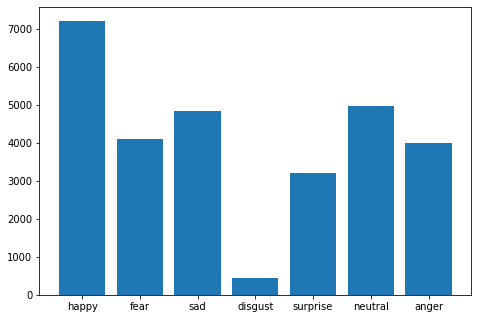

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = fer_classes_t
count_dict_fert = iw.counter_samples_on_class(data_train_fer)
x_1 = [count_dict_fert[cl] for cl in count_dict_fert.keys()]
ax.bar(langs, x_1)
plt.show()

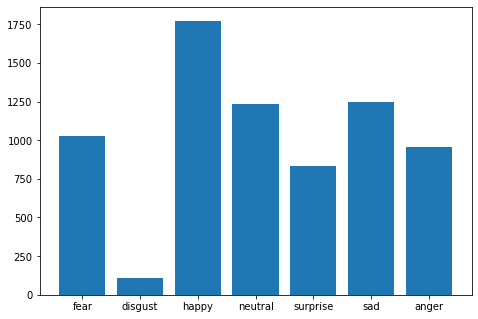

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = fer_classes_v
count_dict_ferv = iw.counter_samples_on_class(data_val_fer)
x_2 = [count_dict_ferv[cl] for cl in count_dict_ferv.keys()]
ax.bar(langs, x_2)
plt.show()

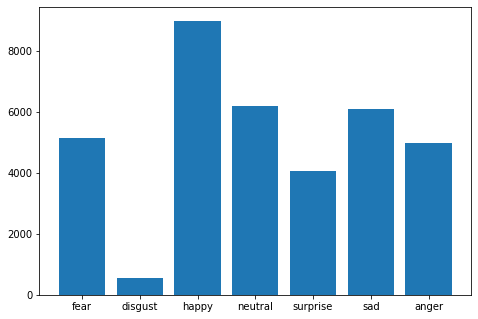

In [ ]:
tot_cl={}
for cl in count_dict_ferv.keys():
  tot_cl[cl] = count_dict_ferv[cl] + count_dict_fert[cl]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = tot_cl.keys()
x_tot = [tot_cl[cl] for cl in langs]
ax.bar(langs, x_tot)
plt.show()

FER2013 don't have so many samples for the disgust class. This observation guarantee a good motivation to merge it with other dataset and, also, for data augmentation phase. Furthermore, it is unbalanced and we needs to manage it in data augmentation or data integration with some samples from other datasets to make a result set which have the same number of samples for each class.

70


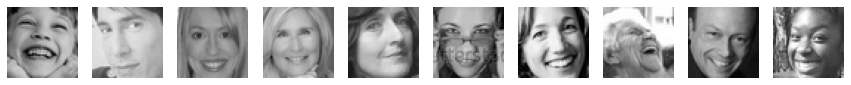

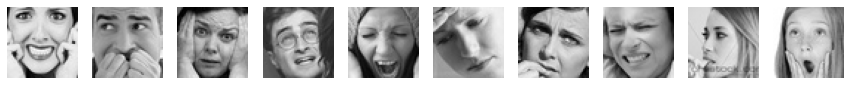

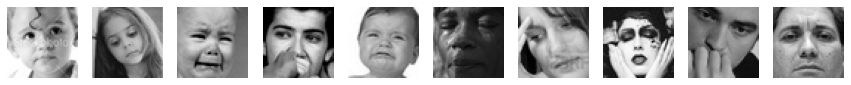

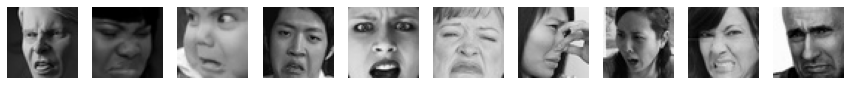

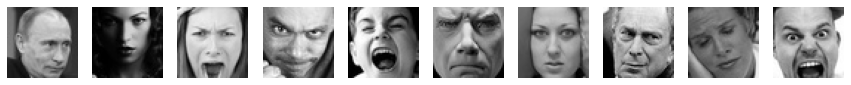

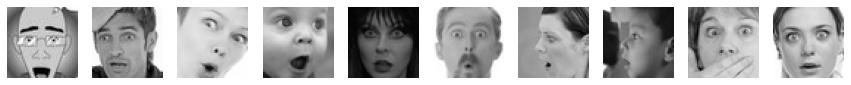

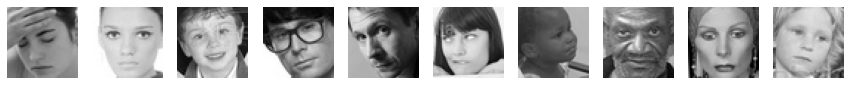

In [ ]:
paths = []
for path in glob.glob("/content/drive/MyDrive/Datasets/FER-2013/train/*"):
  paths.append(path + "/*.jpg")

results = []
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')


This dataset is pretty good in terms of data views, with some variance on the patterns given by a great variability of facial expression for each category. Actually the image size is 48x48, we need to resize in 224x224 size and put together in the same folder of the other datasets for data integration. We will use our ImageWorker object to do that.

In [ ]:
format_fer = "jpg"
source_type = "fer_2013"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in fer_classes_t]
sources = ["/content/drive/MyDrive/Datasets/FER-2013/train/" + class_ for class_ in fer_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

The data integration phase didn't have any distinction between train and test splitting. So, we can merge the FER-2013 val set with the training set and split it in a second time. Actually, our interest is to analyze the val set as well as we did with the training set.

In [ ]:
sources = ["/content/drive/MyDrive/Datasets/FER-2013/val/" + class_ + "/" for class_ in fer_classes_t]
source_type = "fer_2013_test"

for i in range(0, len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

### 2.2  CK+ Dataset
A small dataset composed by 981 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [ ]:
num_classes = 7

data_dir_ck = '/content/drive/My Drive/Datasets/CK+48/*'
ck_classes_t = iw.list_classes(data_dir_ck)
ck_classes_t

['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']

In [ ]:
ck_tot = iw.counter_samples(data_dir_ck)
print("Total no. of images in CK+: ", ck_tot)

Total no. of images in CK+:  986


7
70


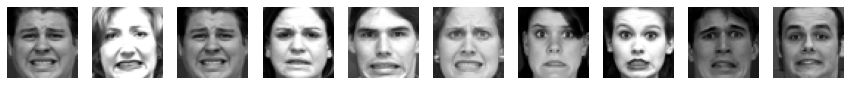

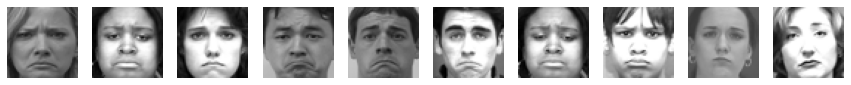

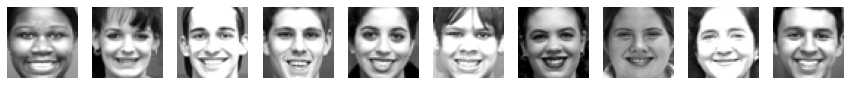

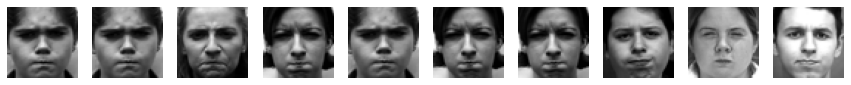

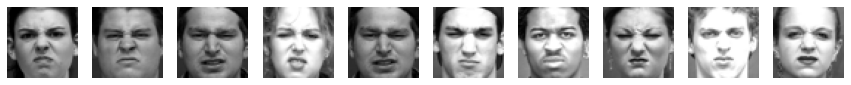

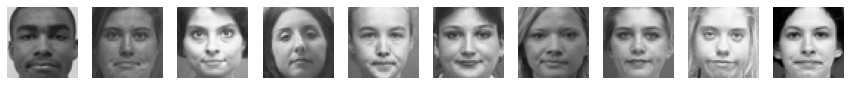

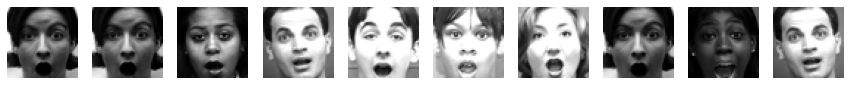

In [ ]:
paths = []
for path in glob.glob(data_dir_ck):
  paths.append(path + "/*.png")

results = []
num_classes = len(ck_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

Actually, the image size is 48x48, to retrieve some data in a common format, we will try to resize them mantaining pixels patterns for data processing. The new size is 224x224 that should mantain in a good way features of the samples. We will save the resized images in a new folder on the drive.

In [ ]:
ck_classes_t

['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']

In [ ]:
format_ck = "png"
source_type = "ck_plus"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in ck_classes_t]
sources = ["/content/drive/MyDrive/Datasets/CK+48/" + class_ for class_ in ck_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

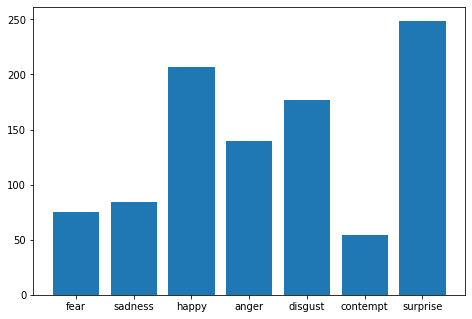

In [ ]:
def plot_dataset(dataset_path):
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  ax.bar(classes, x)
  plt.show()

plot_dataset("/content/drive/MyDrive/Datasets/CK+48/*")

### 2.3 AffectNet Dataset
AffectNet dataset is formed by some samples in different sizes, high-quality images in gray-scale or colored in RGB range. It has 8 different classes (surprise, angry, sad, contempt, disgust, fear, neutral, happy). As the FER-2013, there is a division between testing and training set, we will merge it as well as we did with FER subsets. Furthermore, we resize the different sizes of its images in 256x256 to estabilish the same amount of pixels for each sample.

In [ ]:
num_classes = 8

data_train_af = '/content/drive/My Drive/Datasets/AffectNet/train_class/*'
data_val_af = '/content/drive/My Drive/Datasets/AffectNet/val_class/*'

af_classes_t = iw.list_classes(data_train_af)
af_classes_v = iw.list_classes(data_val_af)

In [ ]:
af_classes_t

['sadness',
 'happy',
 'surprise',
 'neutral',
 'fear',
 'disgust',
 'contempt',
 'anger']

In [ ]:
af_classes_v

['happy',
 'sadness',
 'surprise',
 'fear',
 'neutral',
 'disgust',
 'anger',
 'contempt']

In [ ]:
af_train_tot = iw.counter_samples(data_train_af)
af_val_tot = iw.counter_samples(data_val_af)
af_tot = af_train_tot + af_val_tot
print("Total no. of images in AffectNet: ", af_tot)
print("Total no. of train images in AffectNet:", af_train_tot)
print("Total no. of val images in AffectNet:", af_val_tot)

Total no. of images in AffectNet:  41583
Total no. of train images in AffectNet: 37583
Total no. of val images in AffectNet: 4000


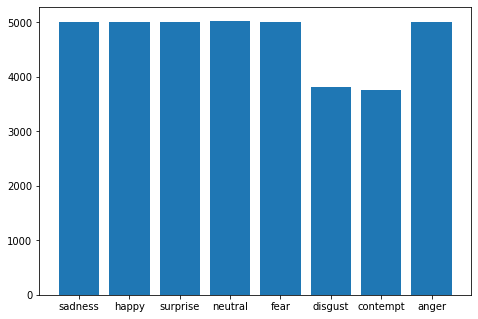

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/AffectNet/train_class/*")

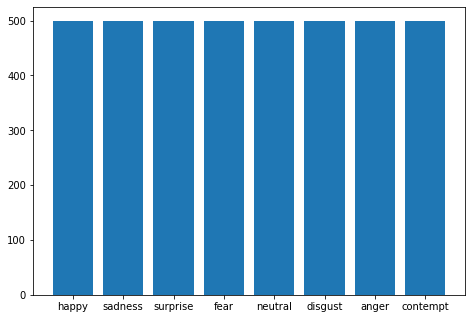

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/AffectNet/val_class/*")

8
80


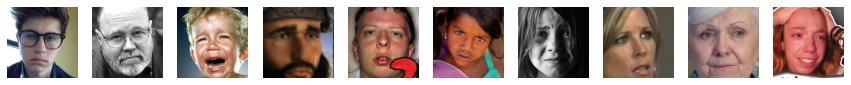

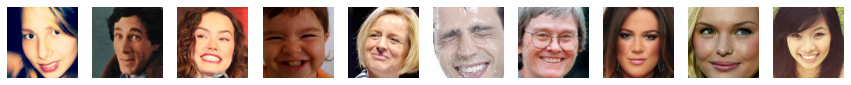

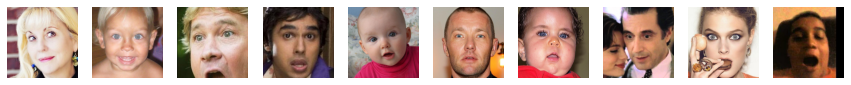

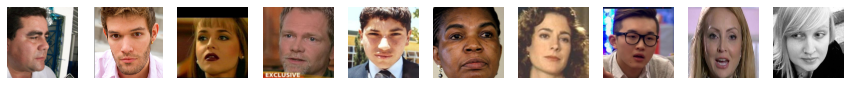

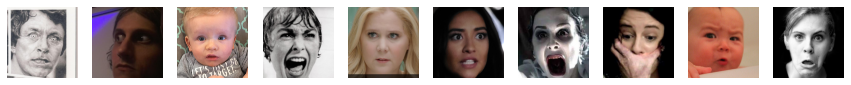

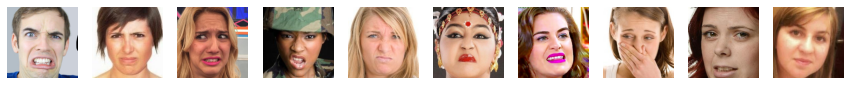

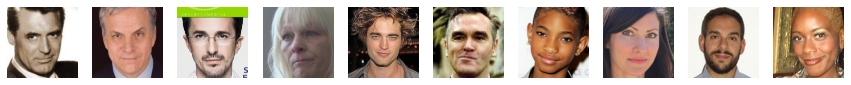

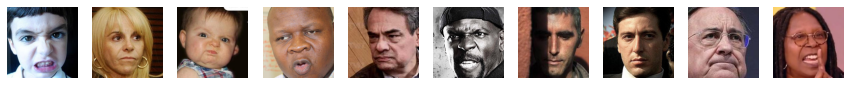

In [ ]:
paths = []
for path in glob.glob(data_train_af):
  paths.append(path + "/*.jpg")

results = []
num_classes = len(af_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [ ]:
# Format of the image in the AffectNet
format_affectnet = "jpg"
source_type = "affect_net"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class" + class_ + "/" for class_ in af_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

In [ ]:
source_type = "affectnet_2"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class" + class_ for class_ in af_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])


### 2.4 ViT Dataset
ViT is the result datasets composed by the integration of images of the 3 different data sources described in the introduction section. It is formed by a mix of gray-scale and rgb-based images with same dimensions divided by subdirectories to divide different classes. We don't have any training/testing splitting yet.

In [ ]:
num_classes = 8

data_vit = '/content/drive/My Drive/Datasets/ViT/*'

classes_vit = iw.list_classes(data_vit)
classes_vit

['anger',
 'neutral',
 'disgust',
 'fear',
 'happy',
 'sadness',
 'surprise',
 'contempt']

In [ ]:
vit_tot = iw.counter_samples(data_vit)
print("Total no. of images in ViT:", vit_tot)

Total no. of images in ViT: 83017


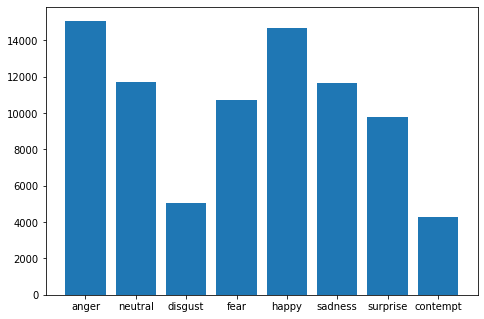

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT/*")

## 3. Data Analysis


Given the result dataset, we are ready to manage samples with procedures of data augmentation and pre-processing to prepare samples for the proposed models.

Firstly, we need to transform images in a common extension. Data from AffectNet and FER-2013 have JPG images meanwhile CK+ has PNG extensions. Considering the total amount of jpg-type images, we will convert every samples in this format.

About the total amount of data are 83.017 different samples, categories like Disgust or Contempt are around 5500 and 5800 different samples respectively. Actually, the dataset is unbalanced so, to solve that, we will execute data augmentation procedures to improves the total number of these categories.

In [ ]:
vit_path = "/content/drive/MyDrive/Datasets/ViT/*"

In [ ]:
classes = iw.list_classes(vit_path)
n_classes = len(classes)
print(f'There are {n_classes} classes:', classes)

There are 8 classes: ['anger', 'neutral', 'disgust', 'fear', 'happy', 'sadness', 'surprise', 'contempt']


In [ ]:
val_c_vit = iw.counter_samples_on_class(vit_path)
print('Number of images per class:', val_c_vit)

Number of images per class: {'anger': 15098, 'neutral': 11728, 'disgust': 5027, 'fear': 10706, 'happy': 14696, 'sadness': 11661, 'surprise': 9797, 'contempt': 4304}


In [ ]:
print("Total no. of images is", iw.counter_samples(vit_path))

Total no. of images is 83017


In [ ]:
categories_data = {}
for class_ in classes:
  categories_data[class_] = {}
  categories_data[class_]["png_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "png")
  categories_data[class_]["jpg_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "jpg")
categories_data

{'anger': {'jpg_count': 14963, 'png_count': 135},
 'contempt': {'jpg_count': 4250, 'png_count': 54},
 'disgust': {'jpg_count': 4850, 'png_count': 177},
 'fear': {'jpg_count': 10631, 'png_count': 75},
 'happy': {'jpg_count': 14489, 'png_count': 207},
 'neutral': {'jpg_count': 11728, 'png_count': 0},
 'sadness': {'jpg_count': 11577, 'png_count': 84},
 'surprise': {'jpg_count': 9548, 'png_count': 249}}

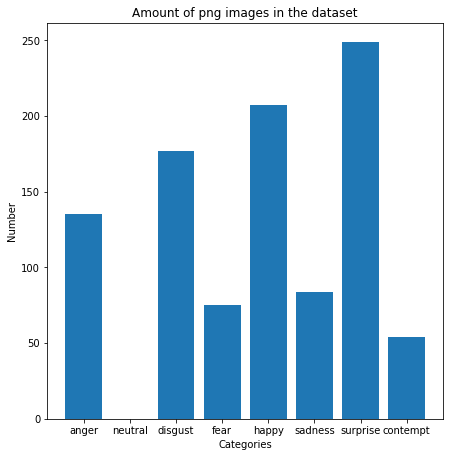

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of png images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

The total amount of data in png are pretty small. That's because we have some samples given by CK+ in this format. CK+ didn't focus so many data, so changing these images in .jpg didn't have huge impact on the dataset noise.



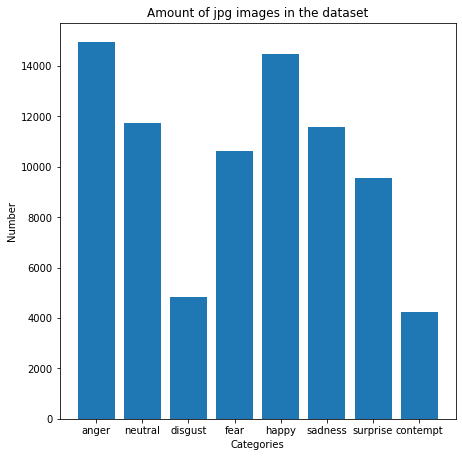

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of jpg images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

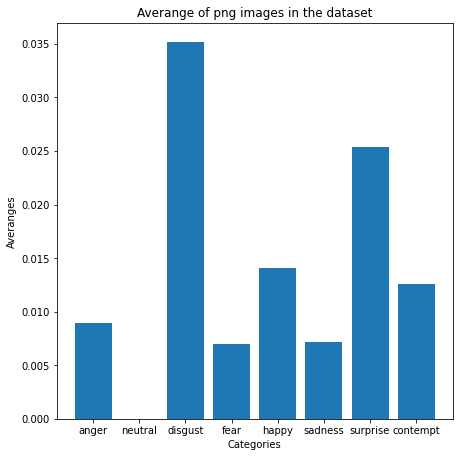

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of png images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

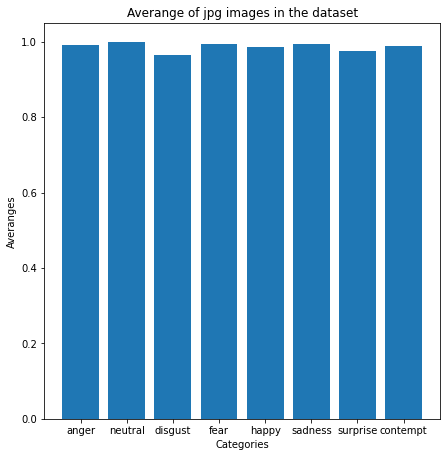

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of jpg images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

A final consideration about the amount of data type in png extension is the less impact in according of the total number of the dataset. According to the last 2 plots, the averange of images in png extension are max in 0.03%. It is good to consider that categories with the maximum averange value are disgust and surprise, that are classes with a small impact for the AffectNet dataset. Generally, converted images can add some noise but, given the small amount of this kind of noised samples, we will mantain them in according to the final application of the model and give an additional variability on the webcam quality.

## 4. Data Augmentation

Data Augmentation is the phase where we will improves the total amount of images for categories with a small number of samples and defines a final balanced version of the ViT dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator(path, 
              format_img, 
              dest_path,
              starting_counter=0, 
              num_augment=1, 
              zoom_range=0.4, 
              brightness_range=(0.2,0.8),
              width_shift_range=0.2,
              height_shift_range=0.2,
              rotation_range=10
              ):
   """generator void

    Args:
      path (str): The source path of the images folder 
      format_img (str): Extension of the image to augment
      dest_path (str): Destination path for the augmented samples
      starting_counter (int): Counter of the namespace to define the augmented elements, default 1
      num_augment (int): Number of augment samples for each image
      zoom_range (float): Range value for the zooming augmentation
      brightness_range (tuple): Range of brightness augmentation
      width_shift_range (float): Augment shifting on width
      height_shift_range (height): Augment shifting on height
      rotation_range (float): Rotation degree for rotation augmentation
    """    
   gen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            brightness_range=brightness_range,
            zoom_range=zoom_range,
            horizontal_flip=True
            )
   print(f'Data Augmentation parameters:\nZoom Range: {zoom_range}\nBrighness Range: {brightness_range}\nShift: ({width_shift_range},{height_shift_range})\nRotation Degrees: {rotation_range}')
   if iw.navigate_path(dest_path) == 0:
      os.mkdir(dest_path)
   num_el = iw.navigate_path(dest_path)
   c = starting_counter
   print('Starting generation...')
   for file in glob.glob(path + "/*." + format_img):
      img = cv2.imread(file)
      # convert to numpy array
      # expand dimension to one sample
      samples = np.expand_dims(img, 0)
      iterator = gen.flow(samples, batch_size=1)
      for i in range(0, num_augment):
          batch = iterator.next()
          image = batch[0].astype('uint8')
          cv2.imwrite(dest_path + "augmented_on_" + str(num_el) + "_" + str(c) + "."+ format_img, image)
          c += 1
   print(f'Data Augmentation for the {path} is done!')


The data augmentation will balance the dataset, so we don't need to setup it for each class but only for categories with a small amount of samples. In according to the data analysis, we obtained some important information about the ViT dataset. It has disgust and contempt classes with the smallest number of data. So, we will operate data augmentation only on samples categorized as one of these two categories.

In [ ]:
augm_class = []

for class_ in classes:
  if categories_data[class_]['jpg_count'] < 5000:
    augm_class.append(class_)

augm_class

['disgust', 'contempt']

In [ ]:
for class_ in augm_class:
  generator("/content/drive/MyDrive/Datasets/ViT/" + class_, "jpg", "/content/drive/MyDrive/Datasets/ViT/" + class_ + "/", 0, num_augment=2)

Data Augmentation parameters:
Zoom Range: 0.4
Brighness Range: (0.2, 0.8)
Shift: (0.2,0.2)
Rotation Degrees: 10
Starting generation...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Data Augmentation for the /content/drive/MyDrive/Datasets/ViT/disgust is done!
Data Augmentation parameters:
Zoom Range: 0.4
Brighness Range: (0.2, 0.8)
Shift: (0.2,0.2)
Rotation Degrees: 10
Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT/contempt is done!


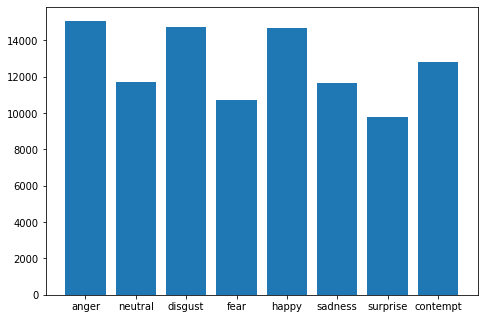

In [ ]:
plot_dataset(vit_path)

In [ ]:
vit_tot = iw.counter_samples(vit_path)
print('The total number of samples now is:', vit_tot)

The total number of samples now is: 101217


In [ ]:
iw.counter_samples_on_class(vit_path)

{'anger': 15098,
 'contempt': 12804,
 'disgust': 14727,
 'fear': 10706,
 'happy': 14696,
 'neutral': 11728,
 'sadness': 11661,
 'surprise': 9797}

Finally, we have a balanced dataset where, for each class, we have at least 9500 different samples. The total amount of data is 101217. During the training phase, dataset we will split in training and validation set in an omogeneus way to maintain consistency of the class variance. The last thing to do in this section is to adapt the .png to the .jpg format; this will make ViT consistent on the number, size and extension.

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/ViT/"
classes_list = iw.list_classes(dataset_path + "*")
from_extension = "png"
to_extension = "jpg"
for el in classes_list:
  print(f'Converting images on {el} class from .{from_extension} to .{to_extension} extension in {dataset_path}{el}')
  iw.extension_converter(dataset_path + el, from_extension, to_extension, dataset_path + el)

Converting images on anger class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/anger
Converting images on neutral class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/neutral
Converting images on disgust class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/disgust
Converting images on fear class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/fear
Converting images on happy class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/happy
Converting images on sadness class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/sadness
Converting images on surprise class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/surprise
Converting images on contempt class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT/contempt


In [ ]:
categories_data = {}
for class_ in classes:
  categories_data[class_] = {}
  categories_data[class_]["png_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "png")
  categories_data[class_]["jpg_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "jpg")
categories_data

{'anger': {'jpg_count': 15098, 'png_count': 0},
 'contempt': {'jpg_count': 12804, 'png_count': 0},
 'disgust': {'jpg_count': 14727, 'png_count': 0},
 'fear': {'jpg_count': 10706, 'png_count': 0},
 'happy': {'jpg_count': 14696, 'png_count': 0},
 'neutral': {'jpg_count': 11728, 'png_count': 0},
 'sadness': {'jpg_count': 11661, 'png_count': 0},
 'surprise': {'jpg_count': 9797, 'png_count': 0}}

ViT Dataset is now composed only by jpg images with 224x224 of dimension, with 3 channels values (RGB) and in a balanced number of samples per class. The next step is to split the dataset in training and validation set, load it and submit to the model training.

## 5. Loading the final dataset

First of all, we need to split it into 2 subset: training and val set. These sets will be in input to the PyTorch Dataset class that estabilish the division as data management system for the training phase.

In [ ]:
import shutil

perc_train = 90
perc_val = 100 - perc_train
val_class = 9700
source_dataset = "/content/drive/MyDrive/Datasets/ViT"
dest_dataset = "/content/drive/MyDrive/Datasets/ViT_dataset"



def calculate_splitting(total, perc):
  return (int)((total * perc) / 100)


def dataset_splitting(source, dest, train, val, max):
  elements = iw.counter_samples_on_class(source + "/*")
  if not os.path.isdir(dest):
    os.mkdir(dest)
  for el in elements.keys():
    if elements[el] < max:
      print('Elements is less than max')
      return False
  train_counter = calculate_splitting(max, train)
  val_counter = max - train_counter
  try:
      os.mkdir(os.path.join(dest, "train"))
      os.mkdir(os.path.join(dest, "val"))
  except FileExistsError:
    pass
  print(f'Number of file in train: {train_counter}')
  print(f'Number of file in val: {val_counter}')
  if val > train:
    print('Validation set is greater than train set')
    return False
  elif os.path.isdir(source) and os.path.isdir(dest):
    for path in glob.glob(source_dataset + "/*"):
      try:
        os.mkdir(os.path.join(dest, "train", os.path.basename(path)))
        os.mkdir(os.path.join(dest, "val", os.path.basename(path)))
      except FileExistsError:
        pass
      train_class = os.path.join(dest, "train", os.path.basename(path))
      val_class = os.path.join(dest,"val", os.path.basename(path))
      train_class_counter = train_counter
      val_class_counter = val_counter
      print(f'Starting copying for the {os.path.basename(path)} class')
      for file in glob.glob(path + "/*.jpg"):
        if train_class_counter > 0:
          train_class_counter -= 1
          shutil.copyfile(file, os.path.join(train_class, os.path.basename(file)))
        elif val_class_counter > 0:
          val_class_counter -= 1
          shutil.copyfile(file, os.path.join(val_class, os.path.basename(file)))
        else:
          break

  else:
    return -1


In [ ]:
%%time
source_dataset = "/content/drive/MyDrive/Datasets/ViT"
dest_dataset = "/content/drive/MyDrive/Datasets/ViT-TV"
dataset_splitting(source_dataset, dest_dataset, perc_train, perc_val, val_class)

Number of file in train: 8730
Number of file in val: 970
Starting copying for the anger class
Starting copying for the neutral class
Starting copying for the disgust class
Starting copying for the fear class
Starting copying for the happy class
Starting copying for the sadness class
Starting copying for the surprise class
Starting copying for the contempt class


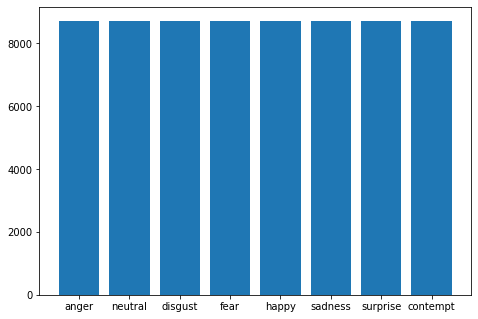

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT-TV/train/*")

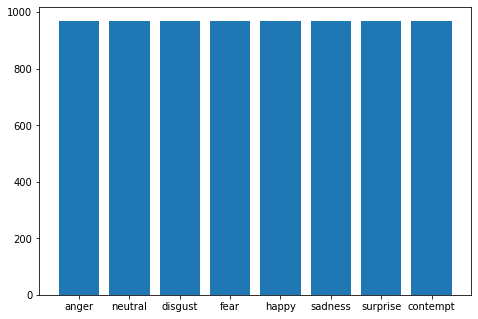

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT-TV/val/*")

In [ ]:
def rename_files(path):
  if os.path.isdir(path):
    classes_list = iw.counter_samples_on_class(path)
    if len(classes_list.keys()) != 0:
      for class_ in classes_list.keys():
         counter_element = classes_list[class_]
         counter = 0
         print(path)
         print(class_)
         print(glob.glob(path + "/*.jpg"))
         for file in glob.glob(path +  "/*.jpg"):
           print(f'Renaming {file} to {os.path.join(path, str(counter) + ".jpg")}')
           os.rename(file, os.path.join(path, str(counter) + ".jpg"))
           counter +=1
      return 0
  else:
      return -1

In [ ]:
base_path = "/content/drive/MyDrive/Datasets/ViT-TV/train"
classes_ = iw.counter_samples_on_class(base_path + "/*")
for val in classes_.keys():
  rename_files(os.path.join(base_path, val))

This phase obtained the aim to divide the dataset in training and validation subset for the transformer submission. Now, we can load it in a Dataset object for the Transformer training.

In [6]:
!pip install timm

     |████████████████████████████████| 431 kB 32.8 MB/s 


In [7]:
import timm, torch
from torchvision import datasets, models, transforms

input_size=(224,224)
batch_size=10
data_dir= "/content/drive/MyDrive/Datasets/ViT-TV/"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
device

device(type='cuda', index=0)

## 6. Training Transformer

## 7. Evaluation

## 8. Export Model